In [1]:
import os

import gcdyn.cycles
from gcdyn.cycles import (
    GC,
    cell_div_balanced_proliferator,
    simple_proliferator,
    binary_proliferator,
)
from gcdyn.phenotype import DMSPhenotype
from gcdyn.fitness import Fitness
from IPython.display import display
from Bio import SeqIO
from plotnine import ggplot, aes, geom_histogram, after_stat, geom_density, facet_grid, theme

In [2]:
fasta_path = "gcreplay_samples/five_seqs.fasta"
seqs = [
    str(seq_record.seq)
    for seq_record in SeqIO.parse(fasta_path, "fasta")
    if seq_record.id != "naive"
]

Trees with balanced proliferator, uniform mutator, dms selector

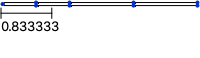

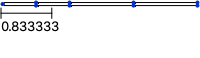

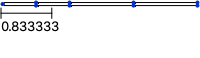

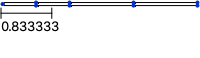

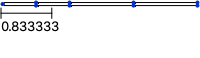

In [3]:
tree_renders = []
dms_cell_div_selector = gcdyn.cycles.DMSSelector(slope=1.32, y_intercept=0)
uniform_mutator = gcdyn.cycles.UniformMutator()

for i in range(len(seqs)):
    seq = seqs[i]
    gc = GC(
        seq,
        cell_div_balanced_proliferator,
        uniform_mutator,
        dms_cell_div_selector,
        N0=1,
        Nmax=50,
    )
    gc.simulate(3, enforce_timescale=True)
    tree_renders.append(gc.tree.render("%%inline", w=200))

for render in tree_renders:
    display(render)

Trees with balanced proliferator, hotspot-aware mutator, dms selector

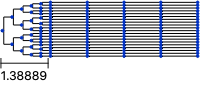

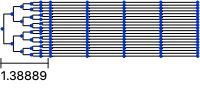

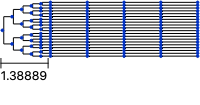

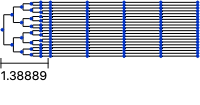

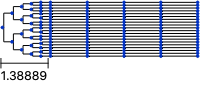

In [4]:
tree_renders = []
dms_cell_div_selector = gcdyn.cycles.DMSSelector(slope=4.37, y_intercept=0)
fivemer_mutator = gcdyn.cycles.FivemerMutator(
    mutability_csv="MK_RS5NF_mutability.csv",
    substitution_csv="MK_RS5NF_substitution.csv",
)
for i in range(len(seqs)):
    seq = seqs[i]
    gc = GC(
        seq,
        cell_div_balanced_proliferator,
        fivemer_mutator,
        dms_cell_div_selector,
        N0=1,
        Nmax=35,
    )
    gc.simulate(5, enforce_timescale=True, competition=True)
    tree_renders.append(gc.tree.render("%%inline", w=200))

for render in tree_renders:
    display(render)

 Trees with balanced proliferator, uniform mutator, uniform selector

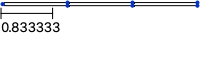

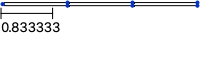

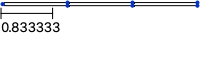

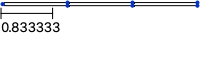

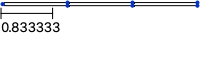

In [5]:
tree_renders = []
uniform_selector = gcdyn.cycles.UniformSelector()
for i in range(len(seqs)):
    seq = seqs[i]
    gc = GC(
        seq,
        cell_div_balanced_proliferator,
        uniform_mutator,
        uniform_selector,
        N0=1,
    )
    gc.simulate(3, enforce_timescale=True)
    tree_renders.append(gc.tree.render("%%inline", w=200))

for render in tree_renders:
    display(render)

Trees with simple proliferator, uniform mutator, dms selector

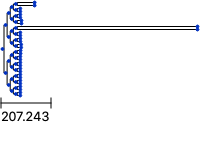

In [6]:
tree_renders = []
dms_selector = gcdyn.cycles.DMSSelector(slope=2.1, y_intercept=0)
for i in range(1):
    seq = seqs[i]
    gc = GC(
        seq,
        simple_proliferator,
        uniform_mutator,
        dms_selector,
        N0=1,
    )
    gc.simulate(3, enforce_timescale=False)
    tree_renders.append(gc.tree.render("%%inline", w=200))

for render in tree_renders:
    display(render)

Binary proliferator, uniform mutator, uniform selector

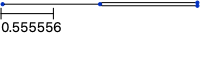

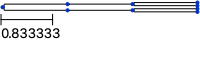

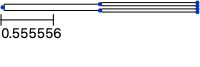

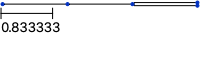

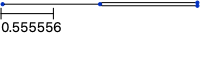

In [7]:
tree_renders = []
for i in range(len(seqs)):
    seq = seqs[i]
    gc = GC(
        seq,
        binary_proliferator,
        uniform_mutator,
        uniform_selector,
        N0=1,
    )
    gc.simulate(3, enforce_timescale=False)
    tree_renders.append(gc.tree.render("%%inline", w=200))

for render in tree_renders:
    display(render)

Look at phenotype trajectory for a simulation of a single cell in a GC

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import seaborn as sns
from matplotlib.colors import SymLogNorm
from ete3 import faces, AttrFace, TreeStyle, NodeStyle, CircleFace

selector = gcdyn.cycles.DMSSelector(slope=3.7, y_intercept=0)

seq = "GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTCAGACTCTGTCCCTCACCTGTTCTGTCACTGGCGACTCCATCACCAGTGGTTACTGGAACTGGATCCGGAAATTCCCAGGGAATAAACTTGAGTACATGGGGTATATAAGCTACAGTGGTACCACTTACTACAATCCATCTCTCAAAAGTCGAATCTCCATCACTCGAGACACATCCAAGAACCAGTACTACCTGCAGTTGCATTCTGTGACTGCTGAGGACACAGCCACATATTACTGTGCAAGGGACTTCGATGTCTGGGGCGCAGGGACCACGGTCACCGTCTCCTCAGACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACAAATGTAGGCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCGTACAGATACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAACAATATAACAACTATCCTCTCACGTTCGGCTCGGGGACTAACCTAGAAATAAAA"
gc = GC(
    seq,
    cell_div_balanced_proliferator,
    fivemer_mutator,
    selector,
    N0=1,
)
gc.simulate(6, enforce_timescale=True, prune=False)
sequences = []
for node in gc.tree.traverse():
    sequences.append(node.sequence)
phenotype = DMSPhenotype(
    1,
    1,
    336,
    "https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv",
    "tdms-linear.model",
    ["delta_log10_KD", "delta_expression", "delta_psr"],
    -10.43,
)
kd_vals = phenotype.calculate_KD(sequences)
seq_to_kd = dict(zip(sequences, kd_vals))

In [9]:
def layout_KD(node):
    node.KD = seq_to_kd[node.sequence]
    if node.is_leaf() or node.is_root():
        faces.add_face_to_node(AttrFace("KD"), node, column=0)
    if node.terminated:
        node.set_style(terminated_style)


terminated_style = NodeStyle()
terminated_style["fgcolor"] = "DarkRed"
ts = TreeStyle()
ts.layout_fn = layout_KD
# gc.tree.render("%%inline", w=300, tree_style=ts)

In [10]:
selector = gcdyn.cycles.DMSSelector(
    fitness_method=Fitness.linear_fitness, slope=5, y_intercept=0.8
)
fivemer_mutator = gcdyn.cycles.FivemerMutator(
    mutability_csv="MK_RS5NF_mutability.csv",
    substitution_csv="MK_RS5NF_substitution.csv",
)

seq = "GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTCAGACTCTGTCCCTCACCTGTTCTGTCACTGGCGACTCCATCACCAGTGGTTACTGGAACTGGATCCGGAAATTCCCAGGGAATAAACTTGAGTACATGGGGTATATAAGCTACAGTGGTACCACTTACTACAATCCATCTCTCAAAAGTCGAATCTCCATCACTCGAGACACATCCAAGAACCAGTACTACCTGCAGTTGCATTCTGTGACTGCTGAGGACACAGCCACATATTACTGTGCAAGGGACTTCGATGTCTGGGGCGCAGGGACCACGGTCACCGTCTCCTCAGACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACAAATGTAGGCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCGTACAGATACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAACAATATAACAACTATCCTCTCACGTTCGGCTCGGGGACTAACCTAGAAATAAAA"
gc = GC(
    seq,
    cell_div_balanced_proliferator,
    fivemer_mutator,
    selector,
    N0=10,
    Nmax=200,
)
gc.simulate(3, enforce_timescale=True, prune=True)
sequences = []
for node in gc.tree.traverse():
    sequences.append(node.sequence)
kd_vals = phenotype.calculate_KD(sequences)
seq_to_kd = dict(zip(sequences, kd_vals))

In [11]:
from ete3 import faces, AttrFace, TreeStyle, NodeStyle, CircleFace


def layout_KD(node):
    node.KD = seq_to_kd[node.sequence]
    if node.is_leaf() or node.is_root():
        faces.add_face_to_node(AttrFace("KD"), node, column=0)
    if node.terminated:
        node.set_style(terminated_style)


terminated_style = NodeStyle()
terminated_style["fgcolor"] = "DarkRed"
ts = TreeStyle()
ts.layout_fn = layout_KD
# gc.tree.render("%%inline", w=300, tree_style=ts)

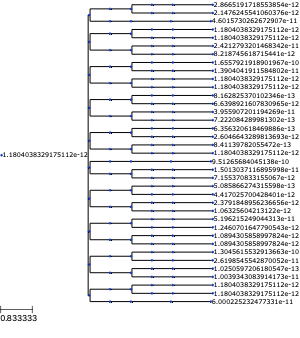

In [12]:
gc.prune()
gc.tree.render("%%inline", w=300, tree_style=ts)

Plotting trajectory of simulated phenotypes in one simulation with three cycles:

/var/folders/qy/y63rpqnw8xn4r6006s6mz6p00000gp/T/ipykernel_8200/1081657697.py:7: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.


Text(0.5, 0, 'cycle number')

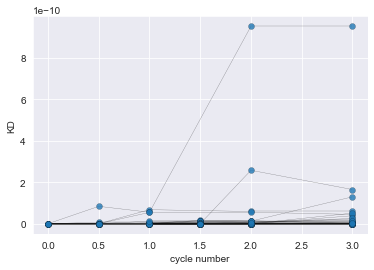

In [13]:
# Adapted from phenotype-trajectories notebook (https://github.com/matsengrp/gcreplay/blob/main/analysis/phenotype-trajectories.ipynb)

points = []
lines = []
colors = []
sim_df = pd.DataFrame()
norm = SymLogNorm(linthresh=1, vmin=0, vmax=10)
cmap = "viridis"

fig, axes = plt.subplots()

alive_descendants = set(
    node for node in gc.tree.get_descendants() if not node.terminated
)

for node in alive_descendants:
    node_phenotype = getattr(node, "KD")
    points.append((gc.tree.get_distance(node), node_phenotype))
    if node.up is not None:
        parent_phenotype = getattr(node.up, "KD")
        lines.append(
            [
                (gc.tree.get_distance(node.up), parent_phenotype),
                (gc.tree.get_distance(node), node_phenotype),
            ]
        )
lc = mc.LineCollection(lines, colors="k", linewidths=0.3, alpha=0.5, zorder=3)
axes.add_collection(lc)
axes.scatter(
    *zip(*points),
    cmap=cmap,
    alpha=0.8,
    edgecolors="k",
    linewidths=0.2,
    zorder=4,
    norm=norm
)
axes.set_ylabel("KD")
axes.set_xlabel("cycle number")

Text(0.5, 0, 'cycle number')

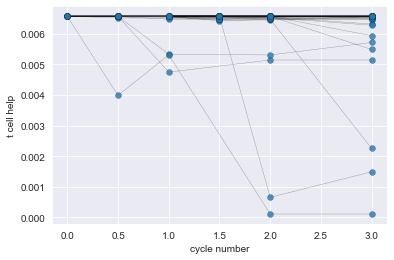

In [14]:
fig, axes = plt.subplots()
points = []
lines = []

fit = Fitness(Fitness.sigmoidal_fitness)
fitness_df = fit.normalized_fitness_df(sequences, calculate_KD=phenotype.calculate_KD)
seq_to_fitness = dict(zip(sequences, fitness_df["normalized_t_cell_help"]))
for node in gc.tree.traverse():
    node_phenotype = seq_to_fitness[node.sequence]
    points.append((gc.tree.get_distance(node), node_phenotype))
    if node.up is not None:
        parent_phenotype = seq_to_fitness[node.up.sequence]
        lines.append(
            [
                (gc.tree.get_distance(node.up), parent_phenotype),
                (gc.tree.get_distance(node), node_phenotype),
            ]
        )
lc = mc.LineCollection(lines, colors="k", linewidths=0.3, alpha=0.5, zorder=3)
axes.add_collection(lc)
axes.scatter(
    *zip(*points), cmap=cmap, alpha=0.8, edgecolors="k", linewidths=0.2, zorder=4
)


axes.set_ylabel("t cell help")
axes.set_xlabel("cycle number")

In [15]:
from math import isclose

all_tfh = []
all_is = []
for i in range(1, 4):
    seqs = [
        node.sequence
        for node in gc.tree.traverse()
        if isclose(node.get_distance(gc.tree), i)
    ]
    i_vals = [str(i)] * len(seqs)
    fit = Fitness(Fitness.sigmoidal_fitness)
    fitness_df = fit.normalized_fitness_df(seqs, calculate_KD=phenotype.calculate_KD)
    seq_to_fitness = dict(zip(sequences, fitness_df["normalized_t_cell_help"]))
    all_tfh.extend(fitness_df["normalized_t_cell_help"])
    all_is.extend(i_vals)

help_df = pd.DataFrame({"normalized_t_cell_help": all_tfh, "cycle_number": all_is})
print(help_df)

    normalized_t_cell_help cycle_number
0                 0.051601            1
1                 0.042041            1
2                 0.051762            1
3                 0.051414            1
4                 0.051762            1
..                     ...          ...
89                0.028259            3
90                0.029576            3
91                0.029286            3
92                0.029554            3
93                0.029554            3

[94 rows x 2 columns]


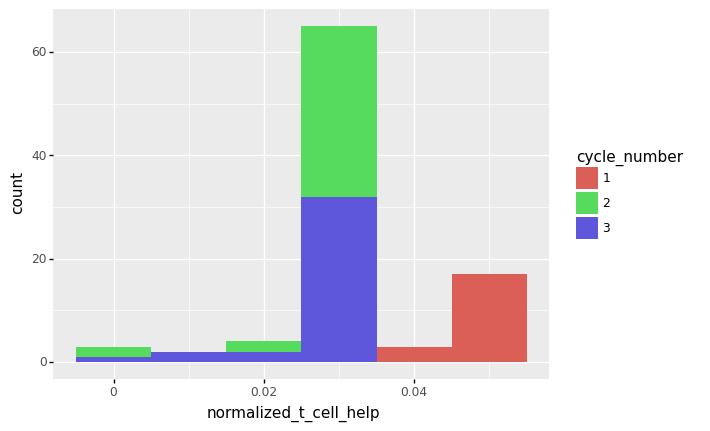

<ggplot: (8792576279848)>

In [16]:


(
    ggplot(
        help_df,
        aes(x="normalized_t_cell_help", y=after_stat("count"), fill="cycle_number"),
    )
    + geom_histogram(binwidth=0.01)
)

In [17]:
threenormselector = gcdyn.cycles.ThreeStepSelector(
    concentration_antigen=10 ** (-10), total_t_cell_help=400, sigmoid_mid_competency=0.5, max_help = 6,
    antigen_frac_limit=0.2, model_path = "tdms-linear.model", tdms_phenotypes=["delta_log10_KD", "delta_expression", "delta_psr"]
)


#gc.tree.render("%%inline", w=300, tree_style=ts)

In [18]:
KDs = []
simulations = []
for i in range(5):
    seq = "GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTCAGACTCTGTCCCTCACCTGTTCTGTCACTGGCGACTCCATCACCAGTGGTTACTGGAACTGGATCCGGAAATTCCCAGGGAATAAACTTGAGTACATGGGGTACATAAGCTACAGTGGTAGCACTTACTACAATCCATCTCTCAAAAGTCGAATCTCCATCACTCGAGACACATCCAAGAACCAGTACTACCTGCAGTTGAATTCTGTGACTACTGAGGACACAGCCACATATTACTGTGCAAGGGACTTCGATGTCTGGGGCGCAGGGACCACGGTCACCGTCTCCTCAGACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACTAATGTAGCCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCCTACAGGTACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAGCAATATAACAGCTATCCTCTCACGTTCGGCTCGGGGACTAAGCTAGAAATAAAA"
    terminated_style = NodeStyle()
    terminated_style["fgcolor"] = "DarkRed"


    gc = GC(seq, cell_div_balanced_proliferator, fivemer_mutator, threenormselector, N0=1)
    gc.simulate(5, enforce_timescale=True, prune=True)


    sequences = []
    for node in gc.tree.traverse():
        if node.is_leaf() and not node.terminated:
            sequences.append(node.sequence)

    kd_vals = phenotype.calculate_KD(sequences)
    KDs.extend(kd_vals)
    simulations.extend([i]*len(kd_vals))
    seq_to_kd = dict(zip(sequences, kd_vals))

def layout_term(node):
    if node.terminated:
        node.set_style(terminated_style)


ts = TreeStyle()
ts.layout_fn = layout_KD

In [19]:
axes.set_xlim((0,4))
axes.set_ylim((0,.5 * 10**(-8)))

axes.set_ylabel("KD")
axes.set_xlabel("cycle number")

Text(0.5, 16.200000000000003, 'cycle number')

In [20]:
fasta_dir = "gcreplay_samples/fastas_KD"
mult_seqs = []
mult_KDs = []
observation_counts = []
i = 14
for file in os.listdir(fasta_dir):
    if file.endswith(".fasta"):
        seqs = [
            str(seq_record.seq)
            for seq_record in SeqIO.parse(f"{fasta_dir}/{file}", "fasta")
            if seq_record.id != "naive"
        ]
        mult_seqs.extend(seqs)
        mult_KDs.extend([
            float(seq_record.id.split("|")[1])
            for seq_record in SeqIO.parse(f"{fasta_dir}/{file}", "fasta")
            if seq_record.id != "naive"
        ])
        observation_counts.extend([i]*len(seqs))
        i += 1
observed_cats = ["observed"]*len(mult_seqs)
simulated_cats = ["simulated"]*len(KDs)


KD_df = pd.DataFrame({"KD": KDs + mult_KDs, "cat": simulated_cats + observed_cats, "count": simulations + observation_counts})


In [21]:
sim_KD_df = pd.DataFrame({"KD": mult_KDs, "sim_count": observation_counts})

In [22]:
print(KD_df)

                KD        cat  count
0     6.390192e-11  simulated      0
1     6.390192e-11  simulated      0
2     3.505763e-11  simulated      0
3     3.505763e-11  simulated      0
4     4.746891e-11  simulated      0
...            ...        ...    ...
5217  1.740194e-12   observed     28
5218  4.403122e-13   observed     28
5219  4.403122e-13   observed     28
5220  5.487564e-13   observed     28
5221  4.880800e-13   observed     28

[5222 rows x 3 columns]


/Users/alyssa/miniconda3/envs/gcdyn_39/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/alyssa/miniconda3/envs/gcdyn_39/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_density : Removed 392 rows containing non-finite values.


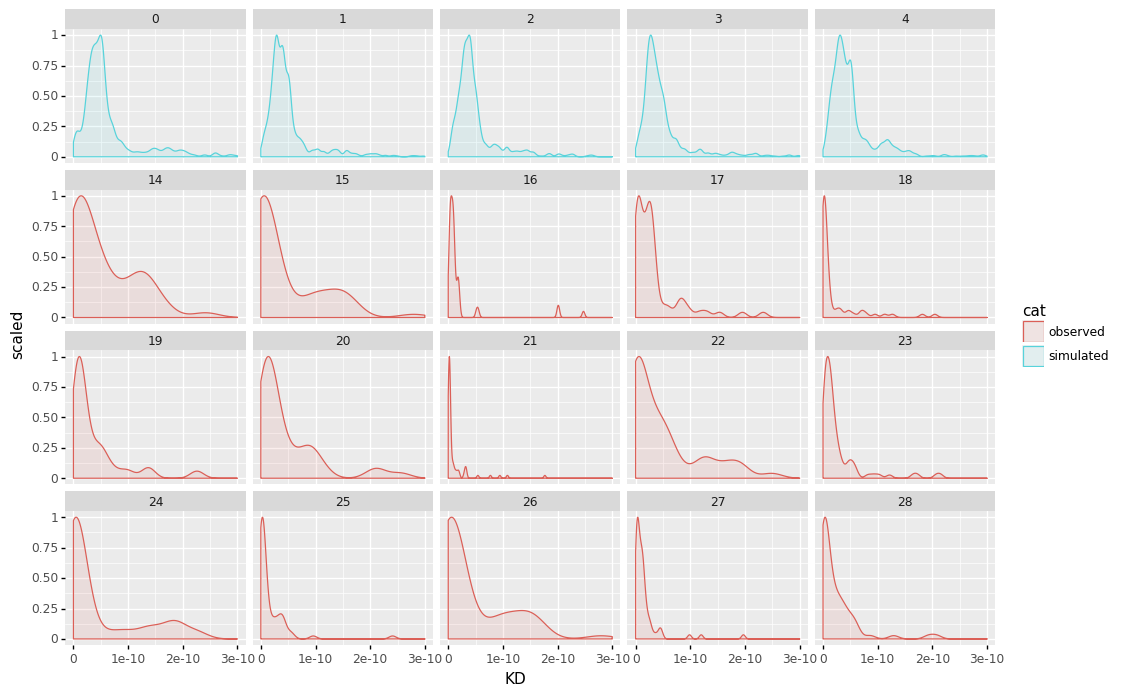

<ggplot: (8792545994237)>

In [23]:
from plotnine import xlim, facet_wrap

(
    ggplot(KD_df, aes(x="KD", color="cat", fill="cat"))
    + geom_density(aes(y=after_stat("scaled")), alpha=0.1)
    + facet_wrap('~count')
    + theme(figure_size = (12,8))
    + xlim(0, 3 * 10 ** (-10))
)